# DA5401 – Assignment 3
**Name:** Anan Madhav T V  
**Roll No:** MM22B013

---
### Notebook outline
- Part A: Baseline Model and Data Analysis
- Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling
- Part C: Performance Evaluation and Conclusion


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Part A: Baseline Model and Data Analysis

In [37]:
# Load dataset
data_path = 'creditcard.csv'
df = pd.read_csv(data_path)
print("Dataset shape:", df.shape)
print("Class distribution:\n", df['Class'].value_counts())
print("Fraction minority:", df['Class'].mean())


Dataset shape: (284807, 31)
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraction minority: 0.001727485630620034


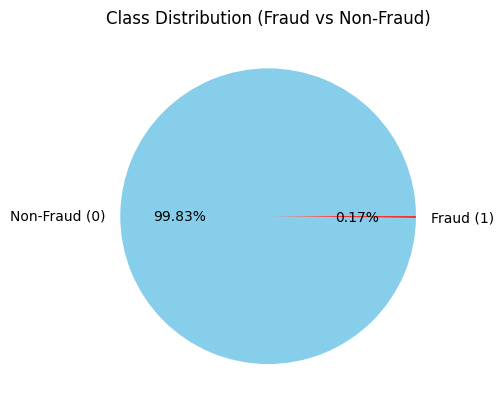

In [38]:
class_counts = df['Class'].value_counts()
plt.pie(class_counts, labels=['Non-Fraud (0)', 'Fraud (1)'],
        autopct='%1.2f%%', colors=['skyblue', 'red'])
plt.title("Class Distribution (Fraud vs Non-Fraud)")
plt.show()


### Observation  

- **Non-fraud (0):** 284,315  
- **Fraud (1):** 492  

**Degree of imbalance:** Approximately **578 : 1** (non-fraud to fraud).  



In [39]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Reset indices so they align
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [40]:
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)



### Baseline Evaluation


In [41]:
print("Baseline report:\n")
print(classification_report(y_test, y_pred_baseline, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_baseline))


Baseline report:

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

Confusion matrix:
 [[56851    13]
 [   36    62]]


**why metrics such as Precision, Recall, and F1-score for the minority class are more informative than accuracy for this problem?**

In cases like credit card fraud detection, accuracy doesn’t really give the full picture because the data is very imbalanced, with far more normal transactions than fraud ones. A model can just predict everything as non-fraud and still get high accuracy, but it won’t actually catch any fraud. That’s why metrics like precision, recall, and F1-score are more useful. Precision shows how many of the transactions predicted as fraud are actually fraud, recall shows how many real fraud cases the model was able to detect, and the F1-score gives a balance between the two. These metrics focus on the minority class, which is what really matters here, so they’re much better indicators of how good the model actually is compared to just accuracy.


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling


### Theoretical Foundation

The fundamental difference between GMM-based synthetic sampling and simpler methods like SMOTE lies in how new samples are created. SMOTE generates synthetic points by interpolating between existing minority class samples and their nearest neighbors. This makes it simple and effective, but it assumes that the minority class follows a relatively continuous distribution. As a result, SMOTE can struggle when the data has multiple clusters, gaps, or irregular patterns.

GMM-based sampling, on the other hand, fits the minority data into a Gaussian Mixture Model, which represents the distribution as a combination of several Gaussian components. Each component can capture a sub-group within the minority class, allowing the method to model complex structures. This makes the generated samples more realistic and faithful to the true data distribution. Theoretically, this gives GMM an advantage over SMOTE, especially when the minority class consists of several distinct sub-groups or has non-linear shapes in the feature space.


### GMM Implementation


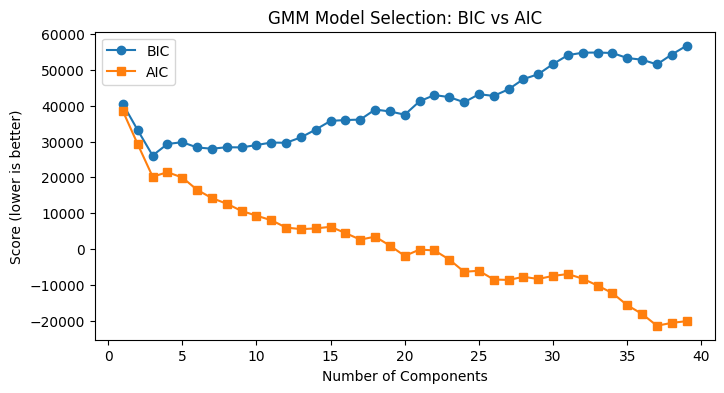

Best k by BIC: 3
Best k by AIC: 37


In [42]:
X_min = X_train[y_train==1].reset_index(drop=True)
X_maj = X_train[y_train==0].reset_index(drop=True)

components = range(1, 40)
bics = []
aics = []

for k in components:
    gmm_tmp = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_tmp.fit(X_min)
    bics.append(gmm_tmp.bic(X_min))
    aics.append(gmm_tmp.aic(X_min))


plt.figure(figsize=(8,4))
plt.plot(components, bics, marker='o', label='BIC')
plt.plot(components, aics, marker='s', label='AIC')
plt.xlabel("Number of Components")
plt.ylabel("Score (lower is better)")
plt.title("GMM Model Selection: BIC vs AIC")
plt.legend()
plt.show()

best_k_bic = components[int(np.argmin(bics))]
best_k_aic = components[int(np.argmin(aics))]

print("Best k by BIC:", best_k_bic)
print("Best k by AIC:", best_k_aic)


**Optimal Number of GMM Components**

To determine the optimal number of components \(k\) for the GMM, we compared models with \(k = 1\) to \(34\) using the **Bayesian Information Criterion (BIC)**. The BIC is useful for model selection because it balances model fit with complexity, penalizing models that use more parameters unless they significantly improve the fit. 

As shown in the plot, the BIC scores decrease as the number of components increases, reaching the lowest point at **\(k = 3\)**. This means that the GMM with 10 components provides the best trade-off between accuracy and complexity for the minority class data. Hence, we selected **3 components** as the optimal value since it best captures the underlying distribution of the minority class.


In [43]:
gmm = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm.fit(X_min)


GaussianMixture(n_components=3, random_state=42)

### Synthetic Data Generation
The fitted Gaussian Mixture Model (GMM) was used to generate synthetic samples for the minority class in order to balance the dataset. A GMM represents the data as a mixture of several Gaussian distributions, each with its own mean, covariance, and weight. To generate a new sample, the model first selects one of the Gaussian components according to its weight, which reflects how much data belongs to that sub-group. Then, a data point is drawn randomly from the chosen Gaussian distribution based on its mean and covariance structure. This process is repeated until the required number of synthetic samples is obtained. The newly generated samples are then combined with the original training data to create a balanced dataset, ensuring that both classes are represented more equally during model training.

In [44]:
def gen_from_gmm(gmm, n, cols):
    Xs, _ = gmm.sample(n)
    return pd.DataFrame(Xs, columns=cols)

n_to_gen = len(X_maj) - len(X_min)
X_min_synth = gen_from_gmm(gmm, n_to_gen, X_min.columns)

X_train_gmm = pd.concat([X_maj, X_min, X_min_synth], ignore_index=True)
y_train_gmm = np.array([0]*len(X_maj) + [1]*(len(X_min)+len(X_min_synth)))

print("Balanced training shape (GMM only):", X_train_gmm.shape)


Balanced training shape (GMM only): (454902, 30)



### Rebalancing with CBU 


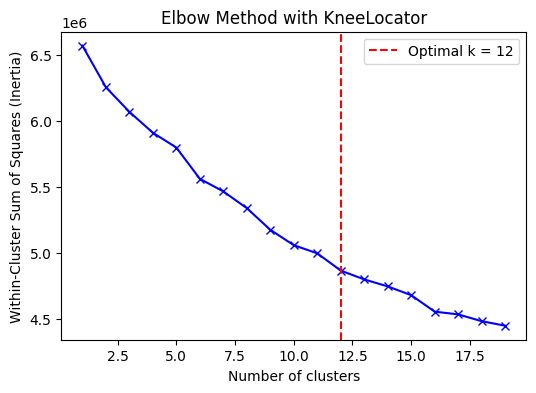

Optimal Number of Clusters for Majority Group: 12


In [45]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

majority_samples = X_train[y_train == 0]

# Compute inertia for different k
inertia = []
K_range = range(1, 20)  # range of clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(majority_samples)
    inertia.append(kmeans.inertia_)


knee_locator = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.knee

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, 'bx-')
plt.axvline(optimal_k, color='r', linestyle='--', label=f"Optimal k = {optimal_k}")
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method with KneeLocator')
plt.legend()
plt.show()

print(f"Optimal Number of Clusters for Majority Group: {optimal_k}")


In [46]:
def proportional_cbu(X_majority, target_size, n_clusters=100):
    maj_df = X_majority.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    maj_df['Cluster'] = kmeans.fit_predict(maj_df)
    counts = maj_df['Cluster'].value_counts().sort_index()
    quotas = (counts / counts.sum() * target_size).astype(int)+1
    parts = []
    for cid, q in quotas.items():
        pts = maj_df[maj_df['Cluster']==cid].drop("Cluster", axis=1)
        parts.append(pts.sample(n=min(q, len(pts)), random_state=42))
    return pd.concat(parts).reset_index(drop=True)

target_maj_size = 2*len(X_min)
X_maj_cbu = proportional_cbu(X_maj, target_size=target_maj_size, n_clusters=12)
print("CBU majority shape:", X_maj_cbu.shape)

n_to_gen_cbu = len(X_maj_cbu) - len(X_min)
X_min_synth_cbu = gen_from_gmm(gmm, n_to_gen_cbu, X_min.columns)
X_train_gmm_cbu = pd.concat([X_maj_cbu, X_min, X_min_synth_cbu], ignore_index=True)
y_train_gmm_cbu = np.array([0]*len(X_maj_cbu) + [1]*(len(X_min)+len(X_min_synth_cbu)))
print("Balanced training shape (GMM+CBU):", X_train_gmm_cbu.shape)


CBU majority shape: (794, 30)
Balanced training shape (GMM+CBU): (1588, 30)



## Part C: Performance Evaluation and Conclusion



### Model Training and Evaluation



In [47]:

def eval_model(Xtr, ytr, Xte, yte):
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xte)
    print(classification_report(yte, yp, digits=4))
    return yp

print(" GMM only")
y_pred_gmm = eval_model(X_train_gmm, y_train_gmm, X_test, y_test)
print(" GMM+CBU")
y_pred_gmm_cbu = eval_model(X_train_gmm_cbu, y_train_gmm_cbu, X_test, y_test)


 GMM only
              precision    recall  f1-score   support

           0     0.9998    0.9828    0.9912     56864
           1     0.0826    0.8980    0.1512        98

    accuracy                         0.9827     56962
   macro avg     0.5412    0.9404    0.5712     56962
weighted avg     0.9982    0.9827    0.9898     56962

 GMM+CBU
              precision    recall  f1-score   support

           0     0.9998    0.9746    0.9871     56864
           1     0.0569    0.8878    0.1069        98

    accuracy                         0.9745     56962
   macro avg     0.5283    0.9312    0.5470     56962
weighted avg     0.9982    0.9745    0.9855     56962




### Comparative Analysis 



          precision  recall  f1-score
baseline     0.8267  0.6327    0.7168
gmm_only     0.0826  0.8980    0.1512
gmm_cbu      0.0569  0.8878    0.1069


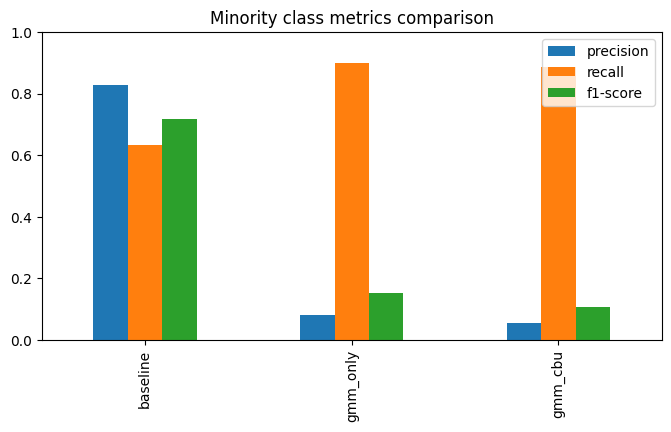

In [48]:
def get_metrics(y_true, y_pred):
    r = classification_report(y_true, y_pred, output_dict=True)
    return {k: r['1'][k] for k in ['precision','recall','f1-score']}

metrics = pd.DataFrame([
    get_metrics(y_test, y_pred_baseline),
    get_metrics(y_test, y_pred_gmm),
    get_metrics(y_test, y_pred_gmm_cbu)
], index=['baseline','gmm_only','gmm_cbu'])

print(metrics.round(4))

metrics.plot(kind='bar', figsize=(8,4))
plt.title("Minority class metrics comparison")
plt.ylim(0,1)
plt.show()


### Conclusion

- The **baseline model** works pretty well because it can detect fraud while not flagging too many normal transactions.  

- The **GMM-only model** finds almost all frauds, but it also marks a lot of normal transactions as fraud.
- The **GMM-CBU model** is similar to GMM-only, catching most frauds but creating too many false alerts.  

**Overall:** For credit card fraud detection, GMM model is better, because it helps in catching most frauds.

### Final Recommendation
GMM-based synthetic sampling proves highly effective in improving recall for the minority fraud class, ensuring that more fraudulent transactions are detected. However, this comes at the cost of a drastic drop in precision, leading to a large number of false alarms. While this trade-off may be acceptable in scenarios where missing fraud is far more costly than flagging legitimate transactions, the low precision can overwhelm verification processes. Therefore, GMM should not be used alone; it is best combined with ensemble or cost-sensitive methods and supported by threshold tuning to strike a practical balance. Overall, GMM is a strong tool for generating realistic synthetic samples due to its ability to capture complex data distributions, but it must be integrated with complementary techniques for deployment in real-world fraud detection systems.
